# 6. Fitting a BL Lac broad-band SED using angpy and Gammapy

In order to perform a fit of the broad-band SED of a jetted AGN, `agnpy` includes a `gammapy` wrapper.
The wrapper defines a custom [SpectralModel](https://docs.gammapy.org/0.20/api/gammapy.modeling.models.SpectralModel.html), representing the emission due to a combination of radiative processes. The `SpectralModel` can be used either to fit flux points or to perform a forward-folding likelihood fit (if the instrument response is available in a format compatible with `gammapy`). 

Several combination of radiative processes can be considered to model the broad-band emission of jetted AGN. For simplicity, we provide wrappers for the two scenarios most-commonly considered:

 * `SycnhrotronSelfComptonModel`, representing the sum of synchrotron and synchrotron self Compton (SSC) radiation. This scenario is commonly considered to model BL Lac sources;

 * `ExternalComptonModel`, representing the sum of synchrotron and synchrotron self Compton radiation along with an external Compton (EC) component. EC scattering can be computed considering a list of target photon fields. This scenario is commonly considered to model flat spectrum radio quasars (FSRQs).

In this tutorial, we will show how to use the `SynchrotronSelfComptonSpectralModel` to fit the broad-band SED of Mrk 421, measured by a MWL campaign in 2009 [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract).

[gammapy](https://gammapy.org/) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pkg_resources

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.fit import SynchrotronSelfComptonModel, load_gammapy_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_y_label

load_mpl_rc()

# import gammapy classes
from gammapy.modeling.models import SkyModel
from gammapy.modeling import Fit

## 6.1. `gammapy` wrapper of agnpy synchrotron and SSC

The `SynchrotronSelfComptonModel` wraps the `agnpy` functions to compute synchrotron and SSC radiation and returns a `gammapy.modeling.SpectralModel`. To initialise this spectral model, only the electron distribution has to be specified, the remaining parameters (the ones of the emission region) will be initialised automatically and can be modified at a later stage.

The `SynchrotronSelfComptonModel` class provides both the `sherpa` and `gammapy` wrappers. You should specify, through the `backend` argument, which package you want to use.

In [2]:
# electron energy distribution
n_e = BrokenPowerLaw(
    k=1e-8 * u.Unit("cm-3"),
    p1=2.02,
    p2=3.43,
    gamma_b=1e5,
    gamma_min=500,
    gamma_max=1e6,
)

# initialise the Gammapy SpectralModel
ssc_model = SynchrotronSelfComptonModel(n_e, backend="gammapy")

Let us set appropriate parameters for the emission region. The size of the blob, $R_{\rm b}$, is set by the variability timescale, $t_{\rm var}$, via

\begin{equation}
R_{\rm b} = \frac{c \delta_{\rm D} t_{\rm var}}{1 + z},
\end{equation}

where $c$ is the speed of light, $\delta_{\rm D}$ the Doppler factor, and $z$ the redshift.

In [3]:
ssc_model.parameters["z"].value = 0.0308
ssc_model.parameters["delta_D"].value = 18
ssc_model.parameters["t_var"].value = (1 * u.d).to_value("s")
ssc_model.parameters["t_var"].frozen = True
ssc_model.parameters["log10_B"].value = -1.3

With the gammapy backend, we can display all the parameters of the model at once

In [4]:
ssc_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str1,int64,float64,float64,bool,bool,str1
spectral,log10_k,-8.0000e+00,,0.000e+00,-1.000e+01,1.000e+01,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,5.0000e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,2.6990e+00,,0.000e+00,0.000e+00,4.000e+00,True,False,
spectral,log10_gamma_max,6.0000e+00,,0.000e+00,4.000e+00,8.000e+00,True,False,
spectral,z,3.0800e-02,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.8000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-1.3000e+00,,0.000e+00,-4.000e+00,2.000e+00,False,False,


or display separately the parameters related to the electrons energy distribution

In [5]:
ssc_model.spectral_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str1,int64,float64,float64,bool,bool,str1
spectral,log10_k,-8.0000e+00,,0.000e+00,-1.000e+01,1.000e+01,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,5.0000e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,2.6990e+00,,0.000e+00,0.000e+00,4.000e+00,True,False,
spectral,log10_gamma_max,6.0000e+00,,0.000e+00,4.000e+00,8.000e+00,True,False,


and the parameters related to the emission region, the blob, in this case

In [6]:
ssc_model.emission_region_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str7,float64,str1,int64,float64,float64,bool,bool,str1
spectral,z,3.0800e-02,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.8000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-1.3000e+00,,0.000e+00,-4.000e+00,2.000e+00,False,False,
spectral,t_var,8.6400e+04,s,0.000e+00,1.000e+01,3.142e+07,True,False,


## 6.2. Fit with `gammapy`
Here we start the procedure to fit with Gammapy.

#### 1) load the MWL flux points, add systematics
A function is provided in `agnpy.fit` to directly load flux points in a list of `gammapy.datasets.FluxPointsDataset` object. It reads the data from a file, included in the package, containing a MWL SED following [these specifications](https://gamma-astro-data-formats.readthedocs.io/en/v0.2/spectra/flux_points/index.html).

The same function allows to add a systematic error on the flux points, this is done with a dictionary specifying the instrument name and the systematic error, expressed as a relative error on the flux. The systematic error is summed in quadrature to the statistical error.

In this example, we use a very rough and conservative estimate of the systematic errors ($30\%$ of the flux for VHE instruments, $10\%$ for HE and X-ray instruments, $5\%$ for all the other instruments).

Specifying the systematic errors through the dictionary is optional.

We can also set the minimum and maximum energy to be used in the fit. We exclude points below $10^{11}\,{\rm Hz}$, as they are measured in the radio band with large integration regions. They hence include the extended emission of the jet, while in our model we are considering the emission from a finite region of the jet, the blob.

In [7]:
sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")

systematics_dict = {
    "Fermi": 0.10,
    "GASP": 0.05,
    "GRT": 0.05,
    "MAGIC": 0.30,
    "MITSuME": 0.05,
    "Medicina": 0.05,
    "Metsahovi": 0.05,
    "NewMexicoSkies": 0.05,
    "Noto": 0.05,
    "OAGH": 0.05,
    "OVRO": 0.05,
    "RATAN": 0.05,
    "ROVOR": 0.05,
    "RXTE/PCA": 0.10,
    "SMA": 0.05,
    "Swift/BAT": 0.10,
    "Swift/UVOT": 0.05,
    "Swift/XRT": 0.10,
    "VLBA(BK150)": 0.05,
    "VLBA(BP143)": 0.05,
    "VLBA(MOJAVE)": 0.05,
    "VLBA_core(BP143)": 0.05,
    "VLBA_core(MOJAVE)": 0.05,
    "WIRO": 0.05,
}

# define minimum and maximum energy to be used in the fit
E_min = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())
E_max = 100 * u.TeV

datasets = load_gammapy_flux_points(sed_path, E_min, E_max, systematics_dict)

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point 

For the gammapy wrapper, we have to define a spectral model and associate it to the list of datasets we obtained from the flux points.

In [8]:
sky_model = SkyModel(spectral_model=ssc_model, name="Mrk421")
datasets.models = [sky_model]

Let us plot all the flux points and the initial model 

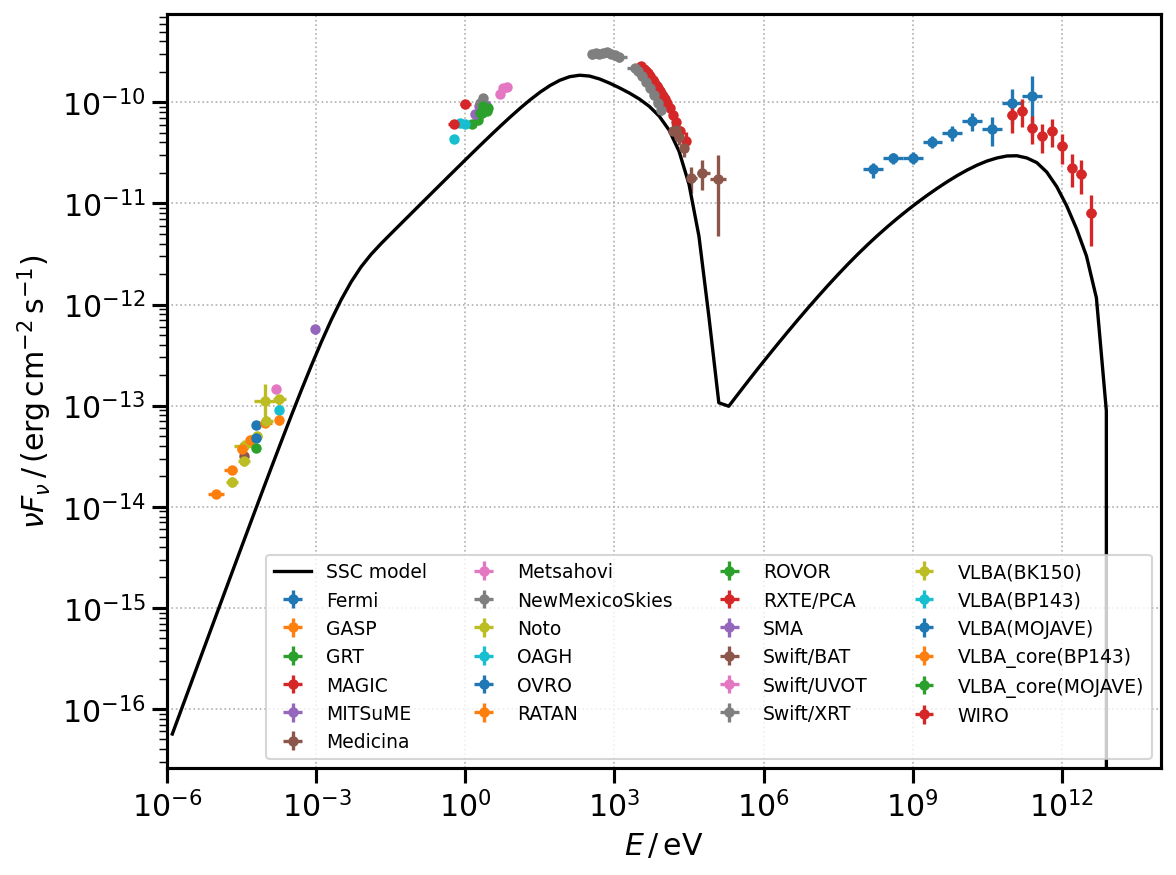

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

for dataset in datasets:
    dataset.data.plot(ax=ax, label=dataset.name)

ssc_model.plot(
    ax=ax,
    energy_bounds=[1e-6, 1e14] * u.eV,
    energy_power=2,
    label="SSC model",
    color="k",
    lw=1.6,
)

ax.set_ylabel(sed_y_label)
ax.set_xlabel(r"$E\,/\,{\rm eV}$")
ax.set_xlim([1e-6, 1e14])
ax.legend(ncol=4, fontsize=9)

plt.show()

#### 2) run the fit

In [10]:
%%time
# define the fitter
fitter = Fit()
results = fitter.run(datasets)

CPU times: user 3min 41s, sys: 27.6 s, total: 4min 9s
Wall time: 4min 10s


In [11]:
print(results)
print(ssc_model.parameters.to_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 342
	total stat : 270.78

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

  type         name         value    unit   error      min        max    frozen is_norm link
-------- --------------- ----------- ---- --------- ---------- --------- ------ ------- ----
spectral         log10_k -7.8836e+00      7.206e-02 -1.000e+01 1.000e+01  False   False     
spectral              p1  2.0541e+00      2.509e-02  1.000e+00 5.000e+00  False   False     
spectral              p2  3.5406e+00      6.162e-02  1.000e+00 5.000e+00  False   False     
spectral   log10_gamma_b  4.9905e+00      2.431e-02  2.000e+00 6.000e+00  False   False     
spectral log10_gamma_min  2.6990e+00      0.000e+00  0.000e+00 4.000e+00   True   False     
spectral log10_gamma_max  6.0000e+00      0.000e+00  4.0

Now let us plot the final model and the flux points

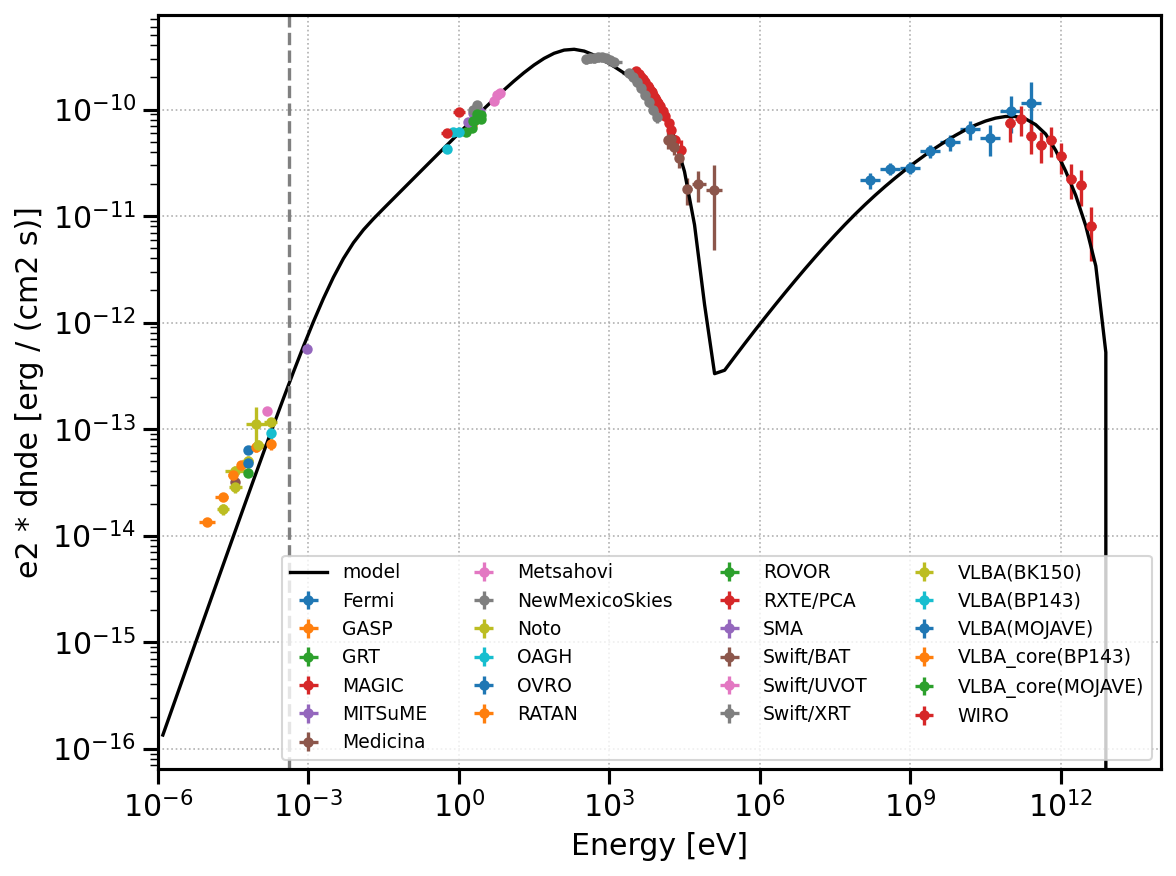

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

for dataset in datasets:
    dataset.data.plot(ax=ax, label=dataset.name)

ssc_model.plot(
    ax=ax,
    energy_bounds=[1e-6, 1e14] * u.eV,
    energy_power=2,
    label="model",
    color="k",
    lw=1.6,
)

# plot a line marking the minimum energy considered in the fit
ax.axvline(E_min, ls="--", color="gray")

plt.legend(ncol=4, fontsize=9)
plt.xlim([1e-6, 1e14])
plt.show()

#### 3) Use Gammapy's functionalities to visualise the fit results

If you want to find more about fitting with gammapy, you can read [this tutorial](https://docs.gammapy.org/0.20.1/tutorials/api/fitting.html). To show the additional capabilities of the fitting with `gammapy`, we illustrate how to visualise the migration matrix and asses the quality of the fit by plotting the likelihood profile of one of the parameters. 

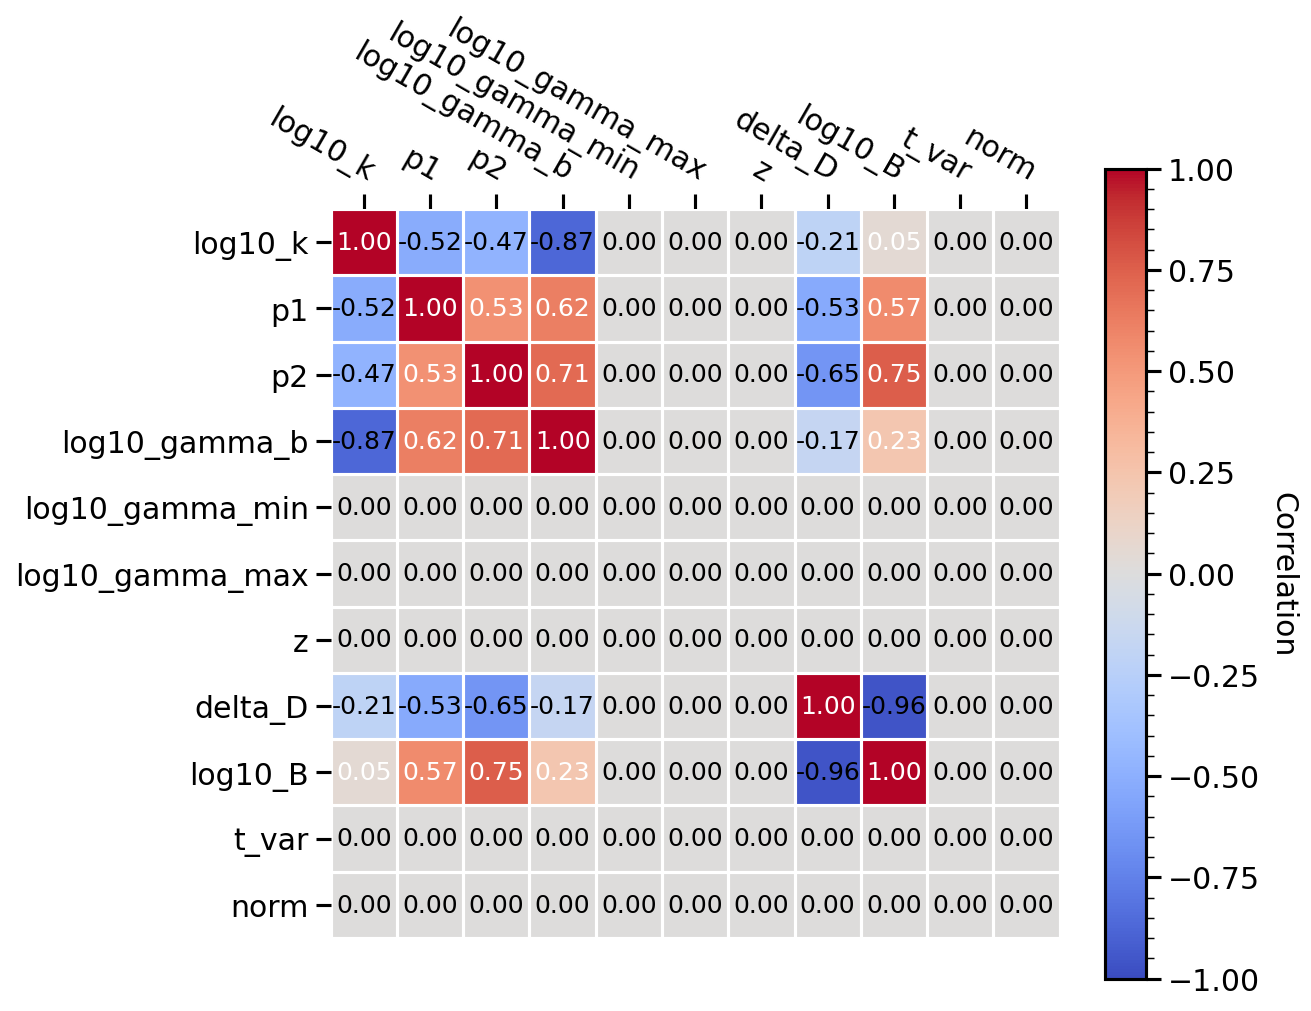

In [13]:
# plot the covariance matrix
ssc_model.covariance.plot_correlation()
plt.grid(False)
plt.show()

In [14]:
%%time
# plot the profile for the normalisation of the electron energy distribution
par = sky_model.spectral_model.log10_k
par.scan_n_values = 50
profile = fitter.stat_profile(datasets=datasets, parameter=par)

# to compute the delta TS
total_stat = results.total_stat

CPU times: user 33.4 s, sys: 4.34 s, total: 37.7 s
Wall time: 38 s


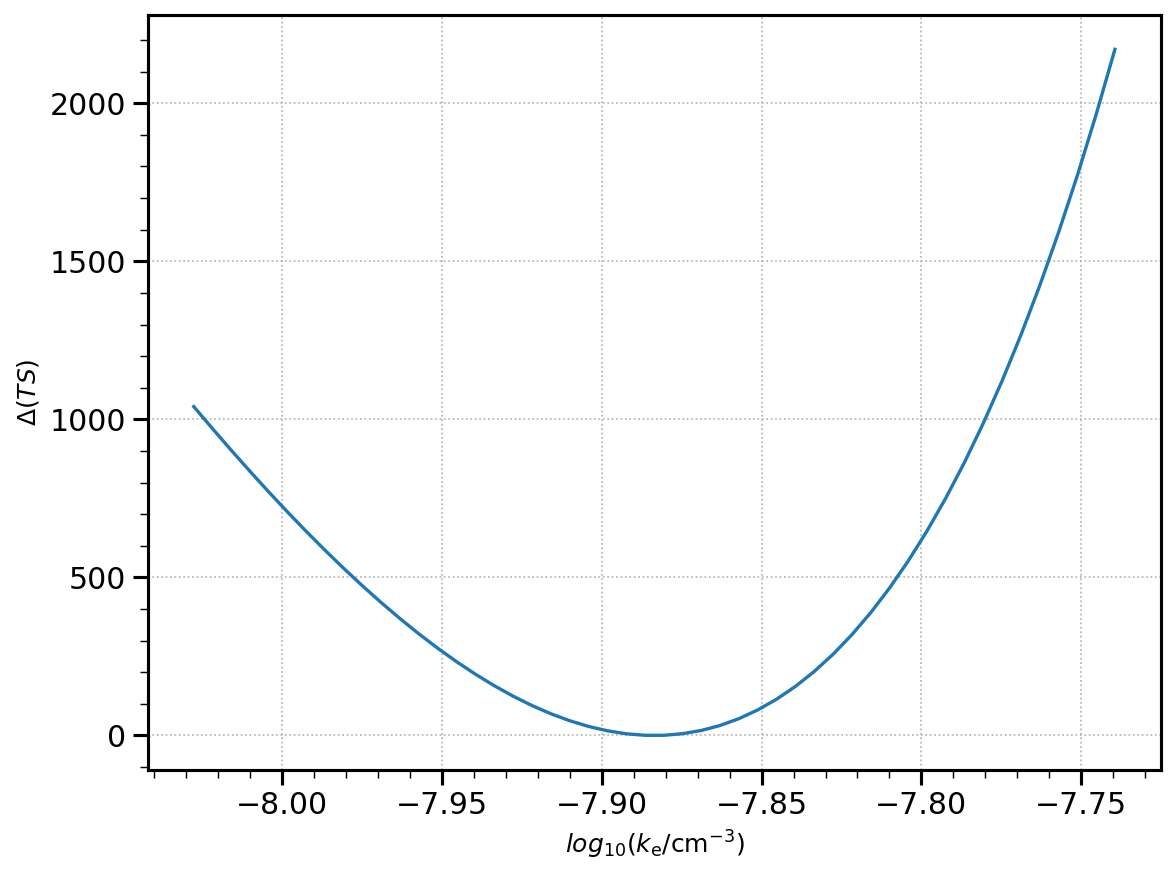

In [17]:
plt.plot(profile["Mrk421.spectral.log10_k_scan"], profile["stat_scan"] - total_stat)
plt.ylabel(r"$\Delta(TS)$", size=12)
plt.xlabel(r"$log_{10}(k_{\rm e} / {\rm cm}^{-3})$", size=12)
plt.show()